# Coursework 2:   Local Feature Detection and matching for object recognition 

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
from scipy.spatial.distance import cdist

# 1. Feature detection

In [2]:
def HarrisPointsDetector(image, k=0.05, sigma=0.5, threshold=None):
    """
    Harris corner detector with optional thresholding for different keypoints count analysis.
    
    :param image: Input grayscale image.
    :param k: Harris detector constant (default 0.05).
    :param sigma: Gaussian smoothing sigma (default 0.5).
    :param threshold: Manual threshold (if None, it uses mean + 2 * std).
    :return: List of OpenCV KeyPoint objects, computed threshold value.
    """

    # Calculate X, Y direction gradients (using 3x3 Sobel)
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)

    # Calculate the elements of the second-order matrix M
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Use 5x5 Gaussian filtering (σ=0.5) to smooth the elements of M
    Sxx = cv2.GaussianBlur(Ixx, (5, 5), sigmaX=sigma, borderType=cv2.BORDER_REFLECT)
    Syy = cv2.GaussianBlur(Iyy, (5, 5), sigmaX=sigma, borderType=cv2.BORDER_REFLECT)
    Sxy = cv2.GaussianBlur(Ixy, (5, 5), sigmaX=sigma, borderType=cv2.BORDER_REFLECT)

    # Calculate the Harris response value R
    detM = (Sxx * Syy) - (Sxy ** 2)
    traceM = Sxx + Syy
    R = detM - k * (traceM ** 2)

    # Normalized Harris response values
    R = cv2.normalize(R, None, 0, 1, cv2.NORM_MINMAX)

    # Default threshold: mean + 2 * standard deviation
    if threshold is None:
        threshold = R.mean() + 2 * R.std()
        # print('Default Threshold value:', threshold)

    # print(f"Threshold used: {threshold}")

    # Non-extreme value suppression (using 7x7 window)
    max_R = ndimage.maximum_filter(R, size=(7, 7))
    corners = (R == max_R) & (R > threshold)

    # Extract keypoint coordinates
    keypoints = np.column_stack(np.where(corners))
    num_kps = len(keypoints)
    # print(f"Number of keypoints detected: {num_kps}")

    # Convert to OpenCV KeyPoint format
    harris_kp = [cv2.KeyPoint(float(x[1]), float(x[0]), 50) for x in keypoints]

    return harris_kp, threshold, num_kps


def draw_keypoints(image, keypoints, title):
    """
    Plotting keypoints
    """
    img_draw = cv2.drawKeypoints(image, keypoints, None, color=(255, 255, 0),
                                 flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_draw, cmap='gray')
    plt.title(title)
    plt.axis("on")


Harris Keypoints Detected: 104


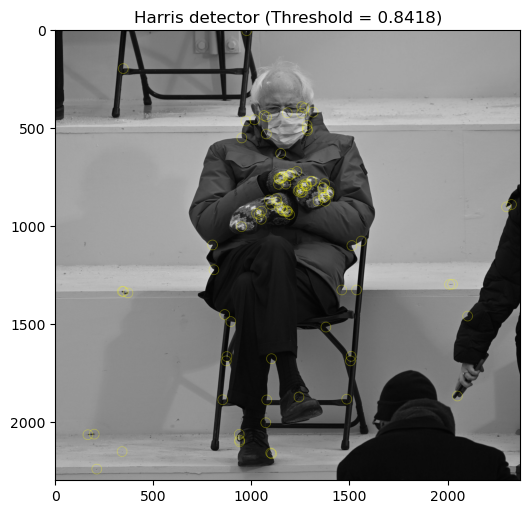

In [3]:

# **Operation Harris corner detection**
image_path = 'images/bernieSanders.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# **Calculation of default Harris corners**
harris_kp, default_threshold, num_harris_kp = HarrisPointsDetector(image)

# **Number of key points inspected**
print(f"Harris Keypoints Detected: {num_harris_kp}")

# **Plotting key points**
draw_keypoints(image, harris_kp, f'Harris detector (Threshold = {default_threshold:.4f})')

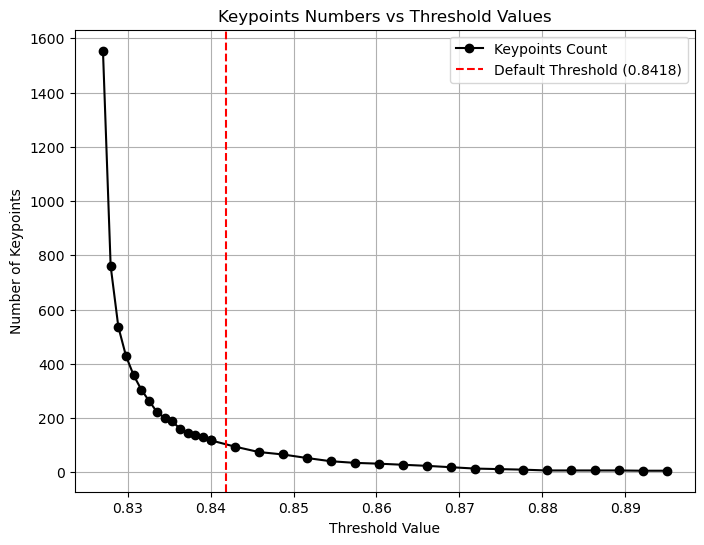

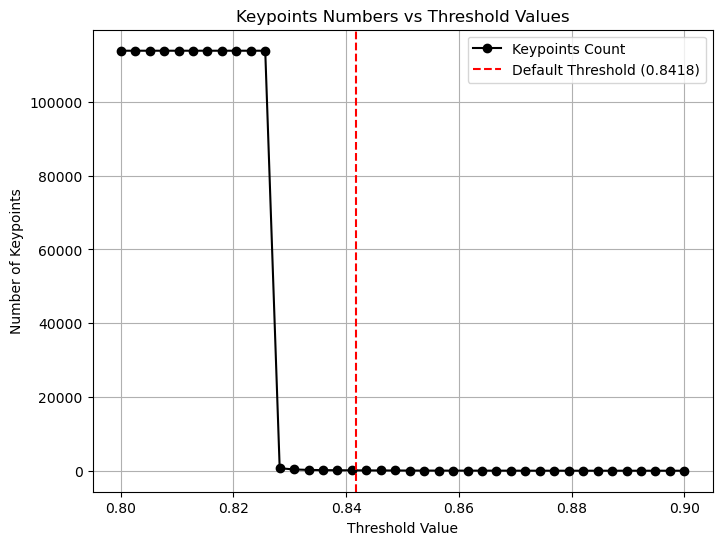

In [17]:
def plot_keypoints_vs_threshold(image, threshold_values, default_threshold):
    """
    Calculate the number of keypoints at different thresholds and plot the curve
    """
    keypoints_counts = []

    for threshold in threshold_values:
        _, _, num_keypoints = HarrisPointsDetector(image, threshold=threshold)
        keypoints_counts.append(num_keypoints)

    # **Plotting images**
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_values, keypoints_counts, marker='o', linestyle='-', color='black', label="Keypoints Count")
    plt.axvline(default_threshold, color='red', linestyle='--', label=f"Default Threshold ({default_threshold:.4f})")
    plt.xlabel("Threshold Value")
    plt.ylabel("Number of Keypoints")
    plt.title("Keypoints Numbers vs Threshold Values")
    plt.legend()
    plt.grid()
    plt.show()


# **Recommended Sampling Range**
threshold_values_high_density = np.linspace(0.827, 0.840, 15)  # Key point number mutation region
threshold_values_low_density = np.linspace(0.840, 0.895, 20)  # Areas of smooth change in the number of key points
threshold_values = np.concatenate((threshold_values_high_density, threshold_values_low_density))

# **Plotting Keypoints vs Threshold**
plot_keypoints_vs_threshold(image, threshold_values, default_threshold)

wide_threshold = np.linspace(0.8, 0.9, 40)
plot_keypoints_vs_threshold(image, wide_threshold, default_threshold)


In [40]:
def resize_image(image, max_height=800):
    """
    Resize the image while maintaining aspect ratio, limiting the maximum height.
    """
    h, w = image.shape[:2]
    if h > max_height:
        scale = max_height / h
        new_size = (int(w * scale), max_height)  # The width is scaled proportionally and the height is set to max_height.
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return image


def find_optimal_threshold(image_path):
    """
    Manually adjust Harris threshold using a trackbar.
    
    :param image_path: Path to the image file.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {image_path}")
        return
    
    original_image = image.copy()
    image = resize_image(image)  # Limit window size
    
    # Compute default threshold
    _, default_threshold, _ = HarrisPointsDetector(image)

    # Create window
    window_name = "Harris Corner Detection"
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)

    # Trackbar callback function
    def on_trackbar(val):
        threshold = val / 1000  # Scale the threshold to [0,1]
        harris_kp, _, num_kps = HarrisPointsDetector(image, threshold=threshold)
        img_with_kp = cv2.drawKeypoints(image, harris_kp, None, color=(255, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
        
        title_text = f"Threshold: {threshold:.4f} | Keypoints: {num_kps}"
        cv2.setWindowTitle(window_name, title_text)  
        
        global current_img
        current_img = resize_image(img_with_kp)
        cv2.imshow(window_name, current_img)

    # Create trackbar (0-1000 range, scaled to 0-1)
    cv2.createTrackbar("Threshold", "Harris Corner Detection", int(default_threshold * 1000), 1000, on_trackbar)

    # Show initial result
    on_trackbar(int(default_threshold * 1000))

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC key to exit
            break
        elif key == ord('s'):  # Press the 's' key to save the current image
            save_path = os.path.join("keypoint", os.path.basename(image_path).split('.')[0] + "_adjusted_kp.png")
            cv2.imwrite(save_path, current_img)
            print(f"Saved adjusted keypoint image: {save_path}")
            
    cv2.destroyAllWindows()
    
# Run the function to manually adjust the threshold
image_path = "images/bernieBenefitBeautySalon.jpeg"
find_optimal_threshold(image_path)

# 2. Feature description

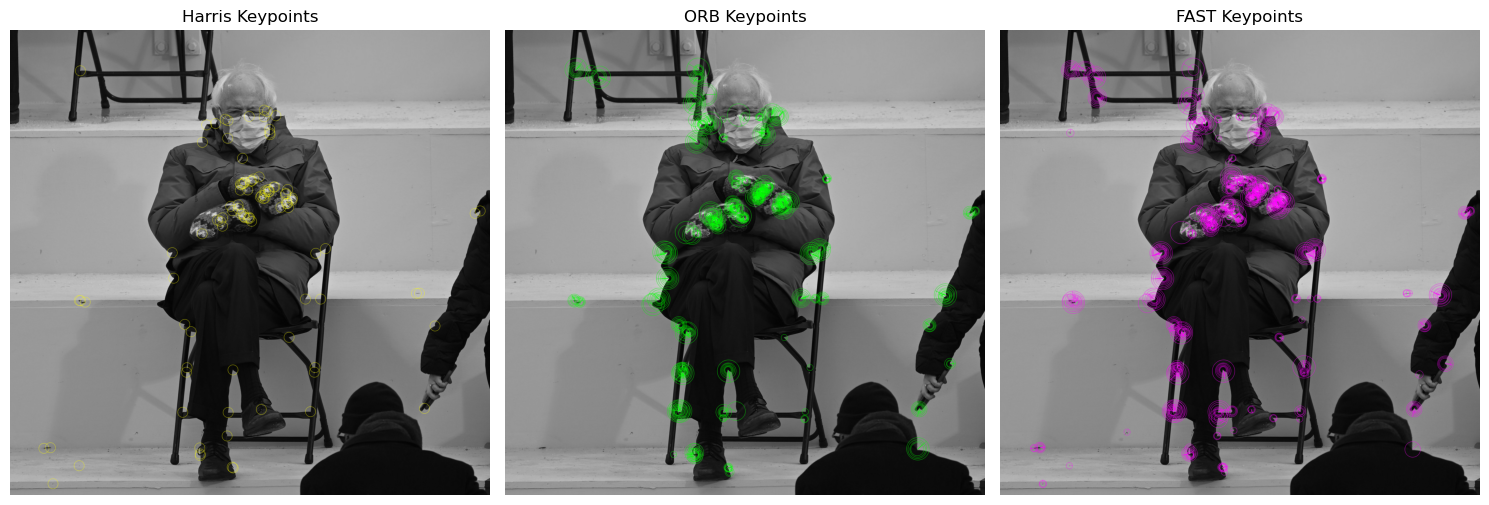

Harris keypoints: 103, Descriptors: (103, 32)
ORB keypoints: 500, Descriptors: (500, 32)
FAST keypoints: 517, Descriptors: (517, 32)


In [4]:
def featureDescriptor(image, keypoints):
    """
    ORB descriptor for calculating Harris corner points
    :param image: input image
    :param keypoints: keypoints from HarrisPointsDetector()
    :return: keypoints and descriptors
    """
    # **Creating an ORB Calculator**
    orb = cv2.ORB_create()

    # **Calculating the ORB Descriptor for Harris Corner Points**
    keypoints, descriptors = orb.compute(image, keypoints)

    # **Convert to NumPy arrays to ensure dimension consistency**
    if descriptors is not None:
        descriptors = np.array(descriptors, dtype=np.uint8)

    return keypoints, descriptors


# Loading image
img = cv2.imread('images/bernieSanders.jpg', cv2.IMREAD_GRAYSCALE)

# **1. Calculate feature points using HarrisPointsDetector **
harris_kp, _, _ = HarrisPointsDetector(img)  # get harris kp from step 1

# **2. Calculation of feature points using ORB**
orb = cv2.ORB_create(scoreType=cv2.ORB_HARRIS_SCORE)
orb_kp = orb.detect(img, None)

# **3. Use of FAST corner detection**
fast = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE)
fast_kp = fast.detect(img, None)

# **Calculated ORB descriptor**
harris_kp, harris_des = featureDescriptor(img, harris_kp)
orb_kp, orb_des = featureDescriptor(img, orb_kp)
fast_kp, fast_des = featureDescriptor(img, fast_kp)

img1 = cv2.drawKeypoints(img, harris_kp, None, color=(255, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv2.drawKeypoints(img, orb_kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img3 = cv2.drawKeypoints(img, fast_kp, None, color=(255, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Create a figure and adjust the layout
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

if img1 is not None:
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title("Harris Keypoints")
    axes[0].axis("off")

if img2 is not None:
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title("ORB Keypoints")
    axes[1].axis("off")

if img3 is not None:
    axes[2].imshow(img3, cmap='gray')
    axes[2].set_title("FAST Keypoints")
    axes[2].axis("off")

plt.tight_layout()
plt.show()

# **Number of printed feature points and descriptors**
print(f"Harris keypoints: {len(harris_kp)}, Descriptors: {harris_des.shape if harris_des is not None else 'None'}")
print(f"ORB keypoints: {len(orb_kp)}, Descriptors: {orb_des.shape if orb_des is not None else 'None'}")
print(f"FAST keypoints: {len(fast_kp)}, Descriptors: {fast_des.shape if fast_des is not None else 'None'}")

# 3. Feature matching 

In [42]:
def SSDFeatureMatcher(des1, des2):
    """
    Use SSD for feature matching, return a list of cv2.DMatch objects
    :param des1: descriptor of the first image
    :param des2: descriptor of the second image
    :return: List of cv2.
    """
    if des1 is None or des2 is None:
        return []

    # **Calculate SSD (sum of squares of L2 norms)**
    ssd_matrix = cdist(des1, des2, metric='sqeuclidean')  # 计算 SSD

    # **Find the best match for each descriptor**
    best_matches = np.argmin(ssd_matrix, axis=1)

    # **Generate OpenCV DMatch objects**
    matches = [cv2.DMatch(_queryIdx=i, _trainIdx=best_matches[i], _distance=ssd_matrix[i, best_matches[i]])
               for i in range(len(des1))]

    return matches


def RatioFeatureMatcher(des1, des2, ratio_threshold=0.8):
    """
    Feature matching using Lowe's Ratio Test returns a list of cv2.DMatch objects
    :param des1: descriptor for the first image
    :param des2: descriptor of the second image
    :param ratio_threshold: Lowe's Ratio Test threshold
    :return: List of cv2.DMatch objects
    """
    if des1 is None or des2 is None:
        return []

    # **Calculate SSD (sum of squares of L2 norms)**
    ssd_matrix = cdist(des1, des2, metric='sqeuclidean')

    # **Find the first two best matches for each descriptor**
    sorted_indices = np.argsort(ssd_matrix, axis=1)[:, :2]

    matches = []
    for i in range(len(des1)):
        best_match_idx = sorted_indices[i, 0]  # Nearest match
        second_best_match_idx = sorted_indices[i, 1]  # Second closest match

        # **Lowe’s Ratio Test**
        if ssd_matrix[i, best_match_idx] < ratio_threshold * ssd_matrix[i, second_best_match_idx]:
            matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=best_match_idx, _distance=ssd_matrix[i, best_match_idx]))

    return matches


def visualize_matches(img1, keypoints1, img2, keypoints2, matches, title, save_path):
    """
    Visualize and save matching results.
    """
    matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.imshow(matched_img)
    plt.title(title)
    plt.axis("off")

    # **Ensure the save directory exists**
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # **Save the image**
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Saved match image: {save_path}")
    plt.close()
    
    
# **Step 1: Read and Resize Images**
img1 = cv2.imread('images/bernieSanders.jpg', cv2.IMREAD_GRAYSCALE)
img2_path = 'images/bernieBenefitBeautySalon.jpeg'
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# Resize images to ensure the same height
img1_resized = resize_image(img1)
img2_resized = resize_image(img2)

# **Step 2: Detect Keypoints and Compute Descriptors**
harris_kp1, _, _ = HarrisPointsDetector(img1_resized, threshold=0.698)
harris_kp2, _, _ = HarrisPointsDetector(img2_resized, threshold=0.535)

harris_kp1, harris_des1 = featureDescriptor(img1_resized, harris_kp1)
harris_kp2, harris_des2 = featureDescriptor(img2_resized, harris_kp2)

# **Step 3: Perform Feature Matching**
ssd_matches = SSDFeatureMatcher(harris_des1, harris_des2)
ratio_matches = RatioFeatureMatcher(harris_des1, harris_des2)

# **Step 4: Define Save Paths**
img2_name = os.path.splitext(os.path.basename(img2_path))[0]
ssd_save_path = f"matches/ssd/{img2_name}_ssd.png"
ratio_save_path = f"matches/ratio/{img2_name}_ratio.png"

# **Step 5: Visualize and Save Matching Results**
visualize_matches(img1_resized, harris_kp1, img2_resized, harris_kp2, ssd_matches, "SSD Feature Matching", ssd_save_path)
visualize_matches(img1_resized, harris_kp1, img2_resized, harris_kp2, ratio_matches, "Ratio Feature Matching", ratio_save_path)

Saved match image: matches/ssd/bernieBenefitBeautySalon_ssd.png
Saved match image: matches/ratio/bernieBenefitBeautySalon_ratio.png
